In [1]:
import numpy as np
import pandas as pd
import random
import cv2
import os
import glob

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, Dense, MaxPooling2D, Activation, Flatten, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
lr = 1e-2
batch_size = 32
epochs = 100
#img_dims = (96,96,3)

### Forming a DataFrame

In [3]:
data = []
labels = []

In [4]:
Img_Dir = [f for f in glob.glob(r'Dataset' + "/**/*",
                                recursive = True) if not os.path.isdir(f)]
random.shuffle(Img_Dir)

In [5]:
df = pd.DataFrame(columns = ["data", "labels"])

In [6]:
for img in Img_Dir:
    image = img
    #image = cv2.resize(image, (img_dims[0], img_dims[1]))
    #image = img_to_array(image)
    data.append(image)
    
     ## labelling the categories
        
    label = image.split(os.path.sep)[-2] 
    if label == "Woman":
        label = 'Female'
    elif label == "Man":
        label = 'Male'
        
    labels.append(label)  # [[1], [0], [0], ...]

In [7]:
df['data'] = data
df['labels'] = labels

## <b><i>EDA</i></b>

In [8]:
df

,data,labels
0,Dataset/Woman/face_1355.jpg,Female
1,Dataset/Woman/face_39.jpg,Female
2,Dataset/Man/face_361.jpg,Male
3,Dataset/Woman/face_512.jpg,Female
4,Dataset/Woman/face_96.jpg,Female
...,...,...
2311,Dataset/Woman/face_847.jpg,Female
2312,Dataset/Man/face_168.jpg,Male
2313,Dataset/Woman/face_661.jpg,Female
2314,Dataset/Woman/face_492.jpg,Female


In [9]:
df.shape

(2316, 2)

In [36]:
df.describe()

,data,labels
count,2316,2316
unique,2316,2
top,Dataset/Woman/face_1355.jpg,Male
freq,1,1173


In [37]:
df.dtypes

data      object
labels    object
dtype: object

### <i>split dataset for training and testing</i>

In [11]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size = 0.2, shuffle = True, random_state = 42)

In [12]:
train_df = pd.DataFrame(columns = ["data", "labels"])
test_df = pd.DataFrame(columns = ["data", "labels"])

In [13]:
train_df

,data,labels


In [14]:
train_df['data'] = x_train
train_df['labels'] = y_train

In [15]:
test_df['data'] = x_test
test_df['labels'] = y_test

### <i>Augmentation</i>

In [16]:
train_DataGen = ImageDataGenerator(rescale = 1/255,
                                   validation_split = 0.8,
                                   rotation_range=25,
                                   horizontal_flip=True,
                                   fill_mode="nearest")

test_DataGen = ImageDataGenerator(rescale = 1/255)

In [17]:
train_images = train_DataGen.flow_from_dataframe(dataframe = train_df,
                                                      x_col = "data",
                                                      y_col = "labels",
                                                      #directory = Img_Dir,
                                                      target_size = (200,200),
                                                      class_mode = "binary",
                                                      seed = 300,
                                                      subset = 'training')

val_images = train_DataGen.flow_from_dataframe(dataframe = train_df,
                                                    x_col = "data",
                                                    y_col = "labels",
                                                    #directory = Img_Dir,
                                                    target_size = (200,200),
                                                    class_mode = "binary",
                                                    seed = 300,
                                                    subset = 'validation')

test_images = test_DataGen.flow_from_dataframe(dataframe = test_df,
                                                      x_col = "data",
                                                      y_col = "labels",
                                                      #directory = Img_Dir,
                                                      target_size = (200,200),
                                                      class_mode = "binary")

Found 371 validated image filenames belonging to 2 classes.
Found 1481 validated image filenames belonging to 2 classes.
Found 464 validated image filenames belonging to 2 classes.


In [18]:
test_images.image_shape

(200, 200, 3)

# <b><i> Defining the Convulational Model</i></b>

#### <i>defining input shape && Model Creation</i>

In [19]:
## defining input shape
#width = img_dims[0]
#height = img_dims[1]
#depth = img_dims[2]
#inputShape = (height, width, depth)
dim = -1

# model creation

model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (4,4), activation = "relu", padding="same", input_shape=(200,200,3)))
model.add(BatchNormalization(axis=dim))
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (4,4), activation = "relu", padding="same"))
model.add(BatchNormalization(axis=dim))

model.add(Conv2D(filters = 64, kernel_size = (4,4), activation = "relu", padding="same"))
model.add(BatchNormalization(axis=dim))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 128, kernel_size = (4,4), activation = "relu", padding="same"))
model.add(BatchNormalization(axis=dim))

model.add(Conv2D(filters = 256, kernel_size = (4,4), activation = "relu", padding="same"))
model.add(BatchNormalization(axis=dim))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(512, activation = "relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(1024, activation = "relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))



model.add(Dense(1, activation = "sigmoid"))

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 200, 200, 32)      1568      
_________________________________________________________________
batch_normalization (BatchNo (None, 200, 200, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 66, 66, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 66, 66, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 66, 66, 64)        32832     
_________________________________________________________________
batch_normalization_1 (Batch (None, 66, 66, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 66, 66, 64)        6

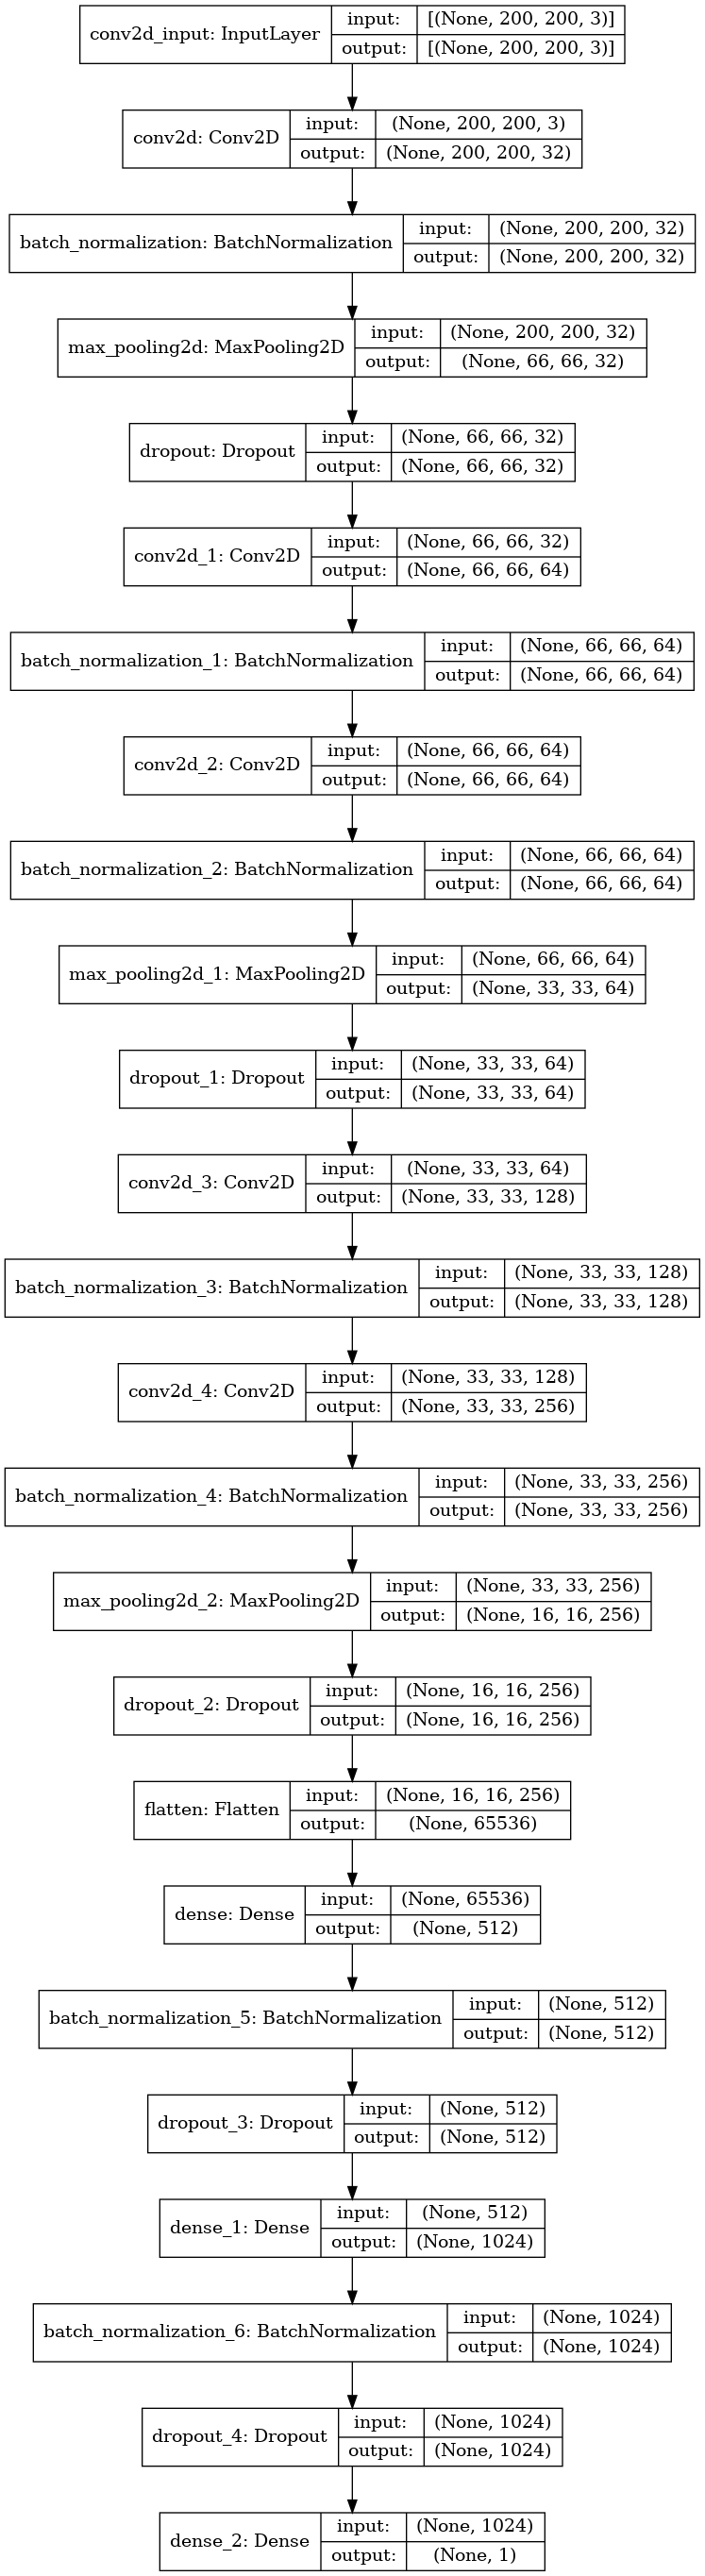

In [21]:
plot_model(model, to_file = 'cnn_model.png', show_shapes=True)

## <b><i>Compile the model</i></b>

In [22]:
opt = Adam(decay = lr/epochs)
model.compile(loss = "binary_crossentropy", optimizer = opt, metrics = ["accuracy"])

In [23]:
es_callback = EarlyStopping(monitor = 'val_accuracy',
                           patience = 3,
                           restore_best_weights = True)

## <b><i>Train the model</i></b>

In [24]:
H = model.fit(train_images, batch_size = batch_size, validation_data = val_images, epochs = epochs, verbose = 1)

Epoch 1/100
12/12 [==============================] - 57s 5s/step - loss: 0.9164 - accuracy: 0.6280 - val_loss: 0.6865 - val_accuracy: 0.5476
Epoch 2/100
12/12 [==============================] - 56s 5s/step - loss: 0.7140 - accuracy: 0.7062 - val_loss: 0.6758 - val_accuracy: 0.5530
Epoch 3/100
12/12 [==============================] - 55s 5s/step - loss: 0.6689 - accuracy: 0.7197 - val_loss: 1.1914 - val_accuracy: 0.5111
Epoch 4/100
12/12 [==============================] - 56s 5s/step - loss: 0.5520 - accuracy: 0.7763 - val_loss: 0.9216 - val_accuracy: 0.6212
Epoch 5/100
12/12 [==============================] - 56s 5s/step - loss: 0.4898 - accuracy: 0.8113 - val_loss: 1.1766 - val_accuracy: 0.5348
Epoch 6/100
12/12 [==============================] - 56s 5s/step - loss: 0.5817 - accuracy: 0.7978 - val_loss: 0.6546 - val_accuracy: 0.6671
Epoch 7/100
12/12 [==============================] - 56s 5s/step - loss: 0.3834 - accuracy: 0.8383 - val_loss: 0.7665 - val_accuracy: 0.6496
Epoch 8/100
1

Epoch 59/100
12/12 [==============================] - 56s 5s/step - loss: 0.1356 - accuracy: 0.9515 - val_loss: 0.4393 - val_accuracy: 0.8643
Epoch 60/100
12/12 [==============================] - 56s 5s/step - loss: 0.1412 - accuracy: 0.9407 - val_loss: 0.3532 - val_accuracy: 0.9034
Epoch 61/100
12/12 [==============================] - 56s 5s/step - loss: 0.1086 - accuracy: 0.9730 - val_loss: 0.3845 - val_accuracy: 0.8839
Epoch 62/100
12/12 [==============================] - 56s 5s/step - loss: 0.1129 - accuracy: 0.9569 - val_loss: 0.3941 - val_accuracy: 0.8947
Epoch 63/100
12/12 [==============================] - 56s 5s/step - loss: 0.0713 - accuracy: 0.9650 - val_loss: 0.3916 - val_accuracy: 0.8906
Epoch 64/100
12/12 [==============================] - 55s 5s/step - loss: 0.0768 - accuracy: 0.9704 - val_loss: 0.4292 - val_accuracy: 0.8953
Epoch 65/100
12/12 [==============================] - 56s 5s/step - loss: 0.0432 - accuracy: 0.9865 - val_loss: 0.3671 - val_accuracy: 0.9014
Epoch 

### <b><i>Saving the model to disk</i></b>

In [25]:
model.save('Gender_Classification.model')

INFO:tensorflow:Assets written to: Gender_Classification.model/assets


### <i>Plot training / validation loss / accuracy</i>

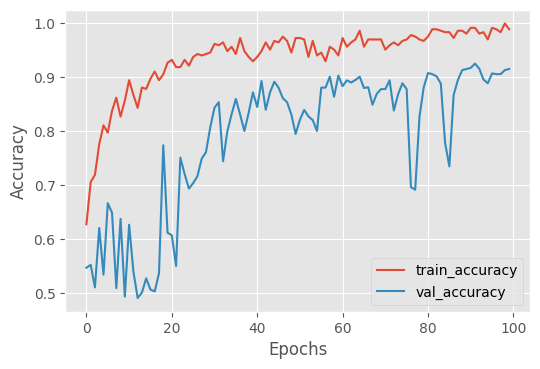

<Figure size 432x288 with 0 Axes>

In [27]:
plt.style.use("ggplot")
plt.figure(dpi = 100)

plt.plot(H.history['accuracy'], label = 'train_accuracy')
plt.plot(H.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.savefig('plot1.png')

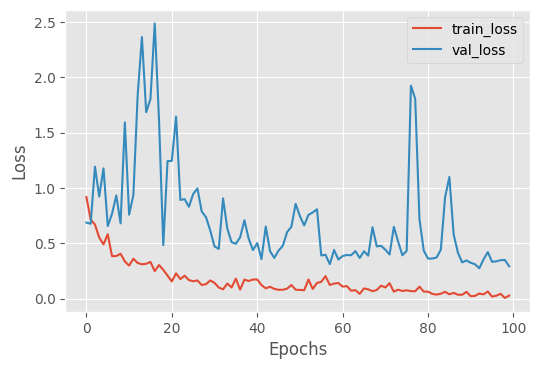

<Figure size 432x288 with 0 Axes>

In [28]:
plt.style.use("ggplot")
plt.figure(dpi = 100)

plt.plot(H.history['loss'], label = 'train_loss')
plt.plot(H.history['val_loss'], label = 'val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.savefig('plot2.png')

### Evaluate the Model

In [29]:
model.evaluate(test_images)

15/15 [==============================] - 7s 482ms/step - loss: 0.2042 - accuracy: 0.9461


[0.20418092608451843, 0.9461206793785095]

In [30]:
test_images.class_indices

{'Female': 0, 'Male': 1}

In [31]:
predict = np.reshape(model.predict(test_images) > 0.6,-1).astype(int)

In [32]:
cn = confusion_matrix(test_images.labels, predict)

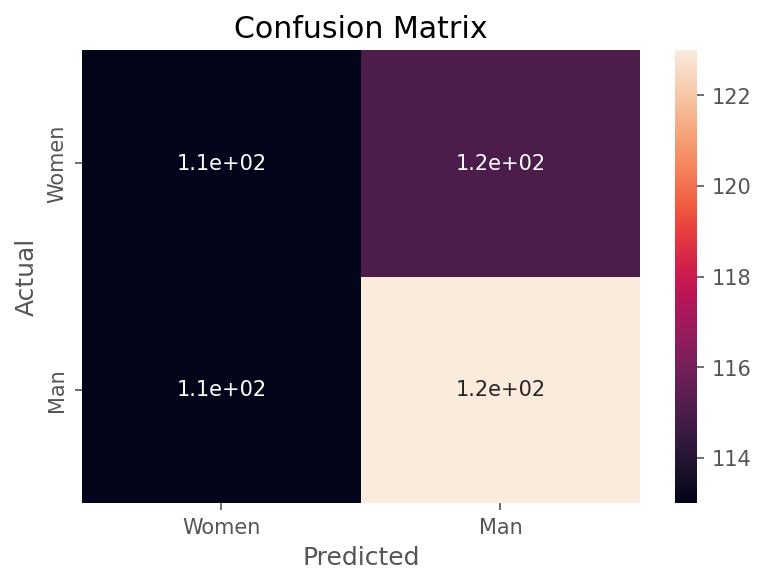

In [33]:
plt.figure(dpi = 150)
sns.heatmap(cn, annot = True)
plt.xticks(ticks=[0.5,1.5], labels=['Women', 'Man'])
plt.yticks(ticks=[0.5,1.5], labels=['Women', 'Man'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [34]:
print(classification_report(test_images.labels, predict))

              precision    recall  f1-score   support

           0       0.50      0.50      0.50       228
           1       0.52      0.52      0.52       236

    accuracy                           0.51       464
   macro avg       0.51      0.51      0.51       464
weighted avg       0.51      0.51      0.51       464



In [35]:
np.unique(test_images.labels, return_counts = True)

(array([0, 1]), array([228, 236]))